Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Большой размер batchsize сокращает время обучения и повышает стабильность. Увеличение размера приведет к ускорению обучения, поскольку на каждой итерации обрабатывается больше данных. Т.е. чем больше батч - тем быстрее сходимость, а когда объектов в батче мало, то модель становится уязвимее от шума в данных.

Посмотрим на какую-нибудь картинку:

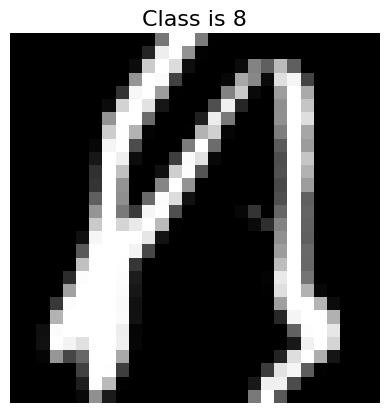

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [ ]:
imgs = []
labels = list(np.unique(trainset.targets.numpy()))
for img in trainset:
    if img[1] in labels:
        labels.remove(img[1])
        imgs.append(img)
    if len(labels) == 0:
        break

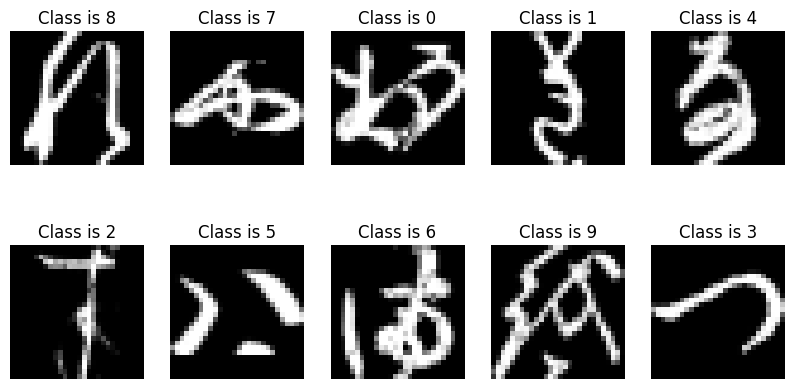

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.ravel()

for i in range(10):
    img, label = imgs[i]
    axs[i].imshow(img.view(28, 28).numpy(), cmap='gray')
    axs[i].set_title(f'Class is {label}')
    axs[i].axis('off')

plt.subplots_adjust(hspace=0.25)
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        # nn.Linear(in_features=, out_features=)
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # vector
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)

        return nn.functional.log_softmax(x, dim=1)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**


Сумма параметров в каждом из линейных слоев = input_features * output_features (веса) + output_features (смещения)

In [ ]:
28 * 28 * 256 + 256 + 256 * 128 + 128 + 128 * 10 + 10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")

Epoch 1, epoch_loss = 0.921
Epoch 2, epoch_loss = 0.444
Epoch 3, epoch_loss = 0.349
Epoch 4, epoch_loss = 0.290
Epoch 5, epoch_loss = 0.247
Epoch 6, epoch_loss = 0.212
Epoch 7, epoch_loss = 0.186
Epoch 8, epoch_loss = 0.162
Epoch 9, epoch_loss = 0.144
Epoch 10, epoch_loss = 0.126


In [ ]:
print(f"Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader):.3f}")

Accuracy на тестовой выборке = 0.870


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean, std = 0, 0

for img, _ in trainset:
    mean += img[0].mean()
    std += img[0].std()

mean = mean / len(trainset)
std = std / len(trainset)
print(f'mean = {mean}, std = {std}')


transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

mean = 0.19176195561885834, std = 0.3385268747806549


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")

Epoch 1, epoch_loss = 0.040
Epoch 2, epoch_loss = 0.032
Epoch 3, epoch_loss = 0.025
Epoch 4, epoch_loss = 0.019
Epoch 5, epoch_loss = 0.016
Epoch 6, epoch_loss = 0.012
Epoch 7, epoch_loss = 0.009
Epoch 8, epoch_loss = 0.007
Epoch 9, epoch_loss = 0.005
Epoch 10, epoch_loss = 0.005


In [ ]:
print(f"Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader):.3f}")

Accuracy на тестовой выборке = 0.905


Как изменилась `accuracy` после нормализации?



Нормализация увеличила `accuracy` с 0.870 до 0.905.


### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
class FCNet_activation(nn.Module):
    def __init__(self, func_activation):
        super().__init__() #  это надо помнить!

        self.func_activation = func_activation
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.func_activation(x)
        x = self.fc2(x)
        x = self.func_activation(x)
        logits = self.fc3(x)

        return logits

In [ ]:
%%time
function = nn.functional.sigmoid
print(f'Activation function is {function.__name__}')

fc_net = FCNet_activation(function)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Activation function is sigmoid
Epoch 1, epoch_loss = 1.545
Epoch 2, epoch_loss = 0.771
Epoch 3, epoch_loss = 0.556
Epoch 4, epoch_loss = 0.450
Epoch 5, epoch_loss = 0.378
Epoch 6, epoch_loss = 0.322
Epoch 7, epoch_loss = 0.278
Epoch 8, epoch_loss = 0.241
Epoch 9, epoch_loss = 0.212
Epoch 10, epoch_loss = 0.186
Accuracy на тестовой выборке = 0.8552
CPU times: user 33.7 s, sys: 3.03 s, total: 36.8 s
Wall time: 2min 31s


In [ ]:
%%time
function = nn.functional.gelu
print(f'Activation function is {function.__name__}')

fc_net = FCNet_activation(function)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Activation function is gelu
Epoch 1, epoch_loss = 0.654
Epoch 2, epoch_loss = 0.285
Epoch 3, epoch_loss = 0.205
Epoch 4, epoch_loss = 0.155
Epoch 5, epoch_loss = 0.121
Epoch 6, epoch_loss = 0.096
Epoch 7, epoch_loss = 0.076
Epoch 8, epoch_loss = 0.060
Epoch 9, epoch_loss = 0.048
Epoch 10, epoch_loss = 0.037
Accuracy на тестовой выборке = 0.9043
CPU times: user 35.4 s, sys: 2.92 s, total: 38.3 s
Wall time: 2min 33s


In [ ]:
%%time
function = nn.functional.tanh
print(f'Activation function is {function.__name__}')

fc_net = FCNet_activation(function)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Activation function is tanh
Epoch 1, epoch_loss = 0.783
Epoch 2, epoch_loss = 0.385
Epoch 3, epoch_loss = 0.260
Epoch 4, epoch_loss = 0.186
Epoch 5, epoch_loss = 0.137
Epoch 6, epoch_loss = 0.103
Epoch 7, epoch_loss = 0.077
Epoch 8, epoch_loss = 0.057
Epoch 9, epoch_loss = 0.042
Epoch 10, epoch_loss = 0.030
Accuracy на тестовой выборке = 0.8983
CPU times: user 34.3 s, sys: 2.91 s, total: 37.2 s
Wall time: 2min 32s


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольший аккураси с функцией gelu (0.904), по скорости обучения лучше всего tanh (2min 31s).

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
from torch.optim import Adam, RMSprop, Adagrad

In [ ]:
%%time
print('Optimizator Adam')
fc_net = FCNet_activation(nn.functional.gelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Optimizator Adam
Epoch 1, epoch_loss = 0.652
Epoch 2, epoch_loss = 0.278
Epoch 3, epoch_loss = 0.202
Epoch 4, epoch_loss = 0.153
Epoch 5, epoch_loss = 0.121
Epoch 6, epoch_loss = 0.095
Epoch 7, epoch_loss = 0.077
Epoch 8, epoch_loss = 0.060
Epoch 9, epoch_loss = 0.049
Epoch 10, epoch_loss = 0.038
Accuracy на тестовой выборке = 0.9019
CPU times: user 36 s, sys: 3.02 s, total: 39 s
Wall time: 2min 56s


In [ ]:
%%time
print('Optimizator RMSprop')
fc_net = FCNet_activation(nn.functional.gelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = RMSprop(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Optimizator RMSprop
Epoch 1, epoch_loss = 0.439
Epoch 2, epoch_loss = 0.235
Epoch 3, epoch_loss = 0.171
Epoch 4, epoch_loss = 0.131
Epoch 5, epoch_loss = 0.102
Epoch 6, epoch_loss = 0.080
Epoch 7, epoch_loss = 0.063
Epoch 8, epoch_loss = 0.049
Epoch 9, epoch_loss = 0.039
Epoch 10, epoch_loss = 0.030
Accuracy на тестовой выборке = 0.8789
CPU times: user 33.2 s, sys: 2.91 s, total: 36.1 s
Wall time: 2min 33s


In [ ]:
%%time
print('Optimizator Adagrad')
fc_net = FCNet_activation(nn.functional.gelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adagrad(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Optimizator Adagrad
Epoch 1, epoch_loss = 1.316
Epoch 2, epoch_loss = 0.792
Epoch 3, epoch_loss = 0.672
Epoch 4, epoch_loss = 0.613
Epoch 5, epoch_loss = 0.575
Epoch 6, epoch_loss = 0.548
Epoch 7, epoch_loss = 0.527
Epoch 8, epoch_loss = 0.510
Epoch 9, epoch_loss = 0.495
Epoch 10, epoch_loss = 0.483
Accuracy на тестовой выборке = 0.7268
CPU times: user 32.3 s, sys: 2.89 s, total: 35.2 s
Wall time: 2min 36s




Быстрее отработал оптимизатор gelu (2min 33s), а самый высокий аккураси дал оптимизатор Adam (accuracy = 0.902).


### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        x = torch.maximum(torch.zeros_like(x), x)
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

Заменим на кастомную функцию

In [ ]:
fc_net = FCNet_activation(CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Epoch 1, epoch_loss = 0.684
Epoch 2, epoch_loss = 0.300
Epoch 3, epoch_loss = 0.217
Epoch 4, epoch_loss = 0.168
Epoch 5, epoch_loss = 0.134
Epoch 6, epoch_loss = 0.110
Epoch 7, epoch_loss = 0.090
Epoch 8, epoch_loss = 0.073
Epoch 9, epoch_loss = 0.060
Epoch 10, epoch_loss = 0.049
Accuracy на тестовой выборке = 0.9002


In [ ]:
custom_predict = []
for i in range(10000):
    img, label = testset[i]
    custom_predict.append(torch.argmax(fc_net(img)))

Теперь делаем нормальный relu

In [ ]:
fc_net = FCNet_activation(nn.functional.relu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # batch for images
        optimizer.zero_grad() # null grad
        outputs = fc_net(images)
        loss = loss_function(outputs, labels) # loss
        loss.backward() # grad
        optimizer.step()

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch {epoch+1}, epoch_loss = {loss_history[epoch]:.3f}")
print(f'Accuracy на тестовой выборке = {get_accuracy(fc_net, testloader)}')

Epoch 1, epoch_loss = 0.682
Epoch 2, epoch_loss = 0.300
Epoch 3, epoch_loss = 0.220
Epoch 4, epoch_loss = 0.172
Epoch 5, epoch_loss = 0.139
Epoch 6, epoch_loss = 0.114
Epoch 7, epoch_loss = 0.093
Epoch 8, epoch_loss = 0.076
Epoch 9, epoch_loss = 0.062
Epoch 10, epoch_loss = 0.051
Accuracy на тестовой выборке = 0.8986


In [ ]:
relu_predict = []
for i in range(10000):
    img, label = testset[i]
    relu_predict.append(torch.argmax(fc_net(img)))

Теперь проверяем

In [ ]:
miss_match = 0
for i, j in zip(relu_predict, custom_predict):
    if i != j:
        miss_match+=1
print(f'Miss matches between relu and custom relu: {miss_match} out of 10000')
print(f'Miss matches to number of elements: {miss_match/len(relu_predict)}')

Miss matches between relu and custom relu: 639 out of 10000
Miss matches to number of elements: 0.0639


### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Кот сидит на подоконнике и смотрит на красивый закат за окном

![1](../data/1.jpg)

Грустный студент делает домашнее задание


![2](../data/2.jpg)

Ярко-красный закат на море

![3](../data/3.jpg)